In [7]:
import pandas as pd
import json
from matplotlib import pyplot as plt
import re
import numpy as np
from nltk.corpus import stopwords 
from collections import Counter
from wordcloud import WordCloud
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import Phrases
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
pd.options.mode.chained_assignment = None  # default='warn'

[nltk_data] Downloading package punkt to C:\Users\Cat
[nltk_data]     Mai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Cat
[nltk_data]     Mai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
video_name = "Jean, Maggie, Liz Buttner 8-13-19.csv"
df = pd.read_csv(video_name)
df


,timestamp,name,text
0,[00:00:04.19],Jean,Uh BlueJeans has this wonderful ability to uh ...
1,[00:00:15.14],Liz,"I sure do, and I took some time as I was sitti..."
2,[00:01:08.00],Jean,OV:Well then you're ready to kind of dive into...
3,[00:01:29.10],Liz,Well you know what I think um[1.5-second-pause...
4,[00:02:58.00],Jean,That's right that's- that's- when we uh Brian ...
...,...,...,...
65,[01:04:01.27],Magige,That'd be very helpful and that would be one o...
66,[01:04:05.04],Liz,Cus that was unique um.
67,[01:04:07.02],Jean,It was very unique and it got out this- our vi...
68,[01:04:38.01],Liz,Thank you that makes me feel very honored. I t...


In [9]:
#using regular expression to clean up gestures [say-hi],[pause] and OV's and the like
stop_words = set(stopwords.words('english')) #set of common words eg and the in at etc
stops = ["um","uh","ah"]
cleaned_text = []

for index,row in df.iterrows():
    text=re.sub(r"OV:|\[.*\]|\(|\)|-{1,}|um", "", row["text"])
    tokens=word_tokenize(text)
    tokens = [w.lower() for w in tokens if w.lower() not in stop_words and w.lower() not in stops]
    tokens =[w for w in tokens if re.match(r"\w+", w)]
    cleaned_text.append(tokens)
    
df["tokens"] = cleaned_text
df = df.loc[(textlist != [] for textlist in df["tokens"])]

#create bigrams
tokens_list=df.groupby(by="text").tokens.first() #check for duplicate texts
bigram = Phrases(tokens_list, min_count=2)

bigrams=[bigram[d] for d in df["tokens"]]
df["bigrams"]=bigrams
df

,timestamp,name,text,tokens,bigrams
0,[00:00:04.19],Jean,Uh BlueJeans has this wonderful ability to uh ...,"[bluejeans, wonderful, ability, record, liz, s...","[bluejeans, wonderful, ability, record, liz, s..."
1,[00:00:15.14],Liz,"I sure do, and I took some time as I was sitti...","[sure, took, time, sitting, outside, pool, yes...","[sure, took, time, sitting, outside, pool, yes..."
2,[00:01:08.00],Jean,OV:Well then you're ready to kind of dive into...,"[well, ready, kind, dive, first, question, ado...","[well, ready, kind, dive, first_question, adop..."
3,[00:01:29.10],Liz,Well you know what I think um[1.5-second-pause...,"[well, know, think, leading, states, n't, want...","[well, know, think, leading, states, n't_want,..."
4,[00:02:58.00],Jean,That's right that's- that's- when we uh Brian ...,"[right, brian, sarah, part, initial, rollout, ...","[right, brian, sarah, part, initial, rollout, ..."
...,...,...,...,...,...
64,[01:03:40.19],Liz,I don't feel like we've spoke very much about ...,"[n't, feel, like, spoke, much, know, state, ed...","[n't_feel, like, spoke, much, know, state, ed,..."
65,[01:04:01.27],Magige,That'd be very helpful and that would be one o...,"[helpful, would, one, things, wan, na, follow]","[helpful, would, one, things, wan_na, follow]"
66,[01:04:05.04],Liz,Cus that was unique um.,"[cus, unique]","[cus, unique]"
67,[01:04:07.02],Jean,It was very unique and it got out this- our vi...,"[unique, got, vision, work, individual, teache...","[unique, got, vision, work, individual, teache..."


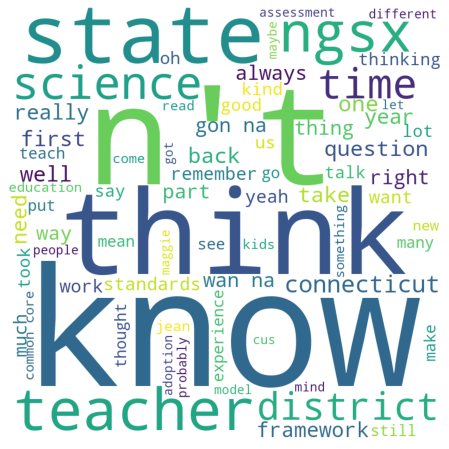

In [10]:
#picture for top words
words=[]
for word in df["tokens"]:
    words.extend(word)
    
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',  
                min_font_size = 20).generate(" ".join(words)) 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.savefig("wordcloud.png")

In [11]:
#automatically detect groups of words - "Topic"

dictionary = Dictionary(df["bigrams"])
corpus=[dictionary.doc2bow(bigramlist) for bigramlist in df["bigrams"]]
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5) 

#create list of words in each topic
big_topic_list = lda_model.show_topics(formatted = False)
big_topic_terms = []

for tup in big_topic_list:
    terms = [liltup[0] for liltup in tup[1]]
    big_topic_terms.append(terms)
    
#find most probable topic associated with each text

topic_prob = []
topic_list = []
topic_terms = []
for d in df["bigrams"]:
    bow = dictionary.doc2bow(d)
    topic_distribution = lda_model.get_document_topics(bow)
    topic=sorted(topic_distribution, key=lambda x:x[1], reverse=True)[0]
    topic_list.append(topic[0])
    topic_prob.append(topic[1])
    topic_terms.append(big_topic_terms[topic[0]])
df["most_probable_topic"]=topic_list
df["topic_terms"] = topic_terms
df["topic_probability"]=topic_prob
df.to_csv("final_data.csv")
df

,timestamp,name,text,tokens,bigrams,most_probable_topic,topic_terms,topic_probability
0,[00:00:04.19],Jean,Uh BlueJeans has this wonderful ability to uh ...,"[bluejeans, wonderful, ability, record, liz, s...","[bluejeans, wonderful, ability, record, liz, s...",3,"[think, n't, ngsx, science, state, know, conne...",0.910804
1,[00:00:15.14],Liz,"I sure do, and I took some time as I was sitti...","[sure, took, time, sitting, outside, pool, yes...","[sure, took, time, sitting, outside, pool, yes...",0,"[know, science, time, ngsx, much, take, think,...",0.983130
2,[00:01:08.00],Jean,OV:Well then you're ready to kind of dive into...,"[well, ready, kind, dive, first, question, ado...","[well, ready, kind, dive, first_question, adop...",4,"[know, think, n't, really, districts, state, n...",0.952208
3,[00:01:29.10],Liz,Well you know what I think um[1.5-second-pause...,"[well, know, think, leading, states, n't, want...","[well, know, think, leading, states, n't_want,...",1,"[know, think, ngsx, teachers, n't, time, state...",0.974673
4,[00:02:58.00],Jean,That's right that's- that's- when we uh Brian ...,"[right, brian, sarah, part, initial, rollout, ...","[right, brian, sarah, part, initial, rollout, ...",4,"[know, think, n't, really, districts, state, n...",0.919104
...,...,...,...,...,...,...,...,...
64,[01:03:40.19],Liz,I don't feel like we've spoke very much about ...,"[n't, feel, like, spoke, much, know, state, ed...","[n't_feel, like, spoke, much, know, state, ed,...",0,"[know, science, time, ngsx, much, take, think,...",0.961381
65,[01:04:01.27],Magige,That'd be very helpful and that would be one o...,"[helpful, would, one, things, wan, na, follow]","[helpful, would, one, things, wan_na, follow]",2,"[know, n't, teachers, think, ngsx, state, time...",0.883763
66,[01:04:05.04],Liz,Cus that was unique um.,"[cus, unique]","[cus, unique]",1,"[know, think, ngsx, teachers, n't, time, state...",0.728484
67,[01:04:07.02],Jean,It was very unique and it got out this- our vi...,"[unique, got, vision, work, individual, teache...","[unique, got, vision, work, individual, teache...",4,"[know, think, n't, really, districts, state, n...",0.499979
